[[  110.29224715   768.96184717]
 [  129.04180608  4403.08213055]
 [  177.99726017   648.1882645 ]
 [  178.00932022  1784.91948822]
 [  190.9124836   3836.40754927]
 [  191.70225493  4377.11868846]
 [  206.16955534  4935.63996801]
 [  245.6145701   3369.43577908]
 [  252.12112148 -1087.08203647]
 [  287.27005942  5838.66357952]
 [  315.97250932  5775.81999729]
 [  362.37821582  5167.42069396]
 [  399.3292421    497.46114154]
 [  400.55750587  3882.31022245]
 [  454.0362889   5677.99942922]
 [  465.99697091  4055.99120107]
 [  516.2213204    627.17574122]
 [  533.08807289  7195.99801394]
 [  575.3571532   5426.48350391]
 [  584.95492608   664.23919145]]


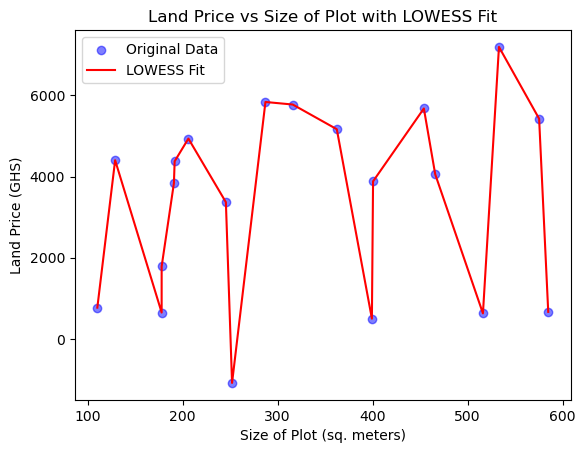

Predicted land price for input [287.27005942  20.29632237   2.09834411  12.77354579]: 4976.685558872731


In [13]:
# Let's first load the dataset to check its structure and then simulate a new dataset with some non-linearity.
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
# Load the dataset from the provided CSV file
file_path = 'full data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()
import numpy as np

# Clean up the 'Land Price (GHS)' column by removing commas and converting to float
data['Land Price (GHS)'] = data['Land Price (GHS)'].replace({',': ''}, regex=True).astype(float)

# Simulate a non-linear version of the dataset
np.random.seed(42)

# Number of samples
num_samples = len(data)

# Simulate the "Size of Plot" feature
size_of_plot = np.random.uniform(100, 600, num_samples)

# Simulate "Distance from Airport" and "Proximity to Main Road" with some randomness
distance_from_airport = np.random.uniform(5, 30, num_samples)
proximity_to_main_road = np.random.uniform(1, 10, num_samples)
proximity_to_city_center = np.random.uniform(5, 25, num_samples)

# Introduce non-linearity in "Land Price"
land_price = (size_of_plot ** 1.2) + (distance_from_airport ** 0.5) * 1000 - (proximity_to_main_road ** 2) * 50 + np.random.normal(0, 2000, num_samples)

# Create a DataFrame for the simulated data
simulated_data = pd.DataFrame({
    'Size of Plot (sq. meters)': size_of_plot,
    'Distance from Airport (km)': distance_from_airport,
    'Proximity to Main Road (km)': proximity_to_main_road,
    'Proximity to City Center (km)': proximity_to_city_center,
    'Land Price (GHS)': land_price
})

# Display the simulated dataset
simulated_data.head()


# Let's focus on the relationship between "Size of Plot" and "Land Price" for the LOWESS model.
# We will use LOWESS to fit a smooth curve to this non-linear data.




# Perform Locally Weighted Regression (LOWESS)
lowess_results = lowess(simulated_data['Land Price (GHS)'], simulated_data['Size of Plot (sq. meters)'], frac=0.001)

print(lowess_results)

# Extract the smoothed values
size_of_plot_smooth = lowess_results[:, 0]
land_price_smooth = lowess_results[:, 1]

# Plot the original data points
plt.scatter(simulated_data['Size of Plot (sq. meters)'], simulated_data['Land Price (GHS)'], color='blue', alpha=0.5, label='Original Data')

# Plot the LOWESS smoothed curve
plt.plot(size_of_plot_smooth, land_price_smooth, color='red', label='LOWESS Fit')

# Add labels and title
plt.xlabel("Size of Plot (sq. meters)")
plt.ylabel("Land Price (GHS)")
plt.title("Land Price vs Size of Plot with LOWESS Fit")
plt.legend()

# Show the plot
plt.show()
# Step 1: Recalculate theta_optimal using the normal equation

# Load features (X) and target (y) from the simulated dataset
X = simulated_data[['Size of Plot (sq. meters)', 'Distance from Airport (km)', 
                    'Proximity to Main Road (km)', 'Proximity to City Center (km)']].values
y = simulated_data['Land Price (GHS)'].values

# Normalize the features (standardization)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

# Add a bias term (intercept) to the normalized features
m = len(y)  # number of examples
X_b = np.c_[np.ones((m, 1)), X_norm]

# Apply the normal equation to find the optimal theta
theta_optimal = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

# Step 2: Make prediction using the new input
new_input = np.array([[287.27005942368123,20.296322368059485,2.0983441136030097,12.77354579378964]])  # Example input

# Normalize the new input based on training data
new_input_norm = (new_input - X_mean) / X_std

# Add bias term to the new input
new_input_b = np.c_[np.ones((new_input_norm.shape[0], 1)), new_input_norm]

# Predict the land price using the optimal theta
predicted_price = new_input_b.dot(theta_optimal)

# Output the predicted price
print(f"Predicted land price for input {new_input[0]}: {predicted_price[0]}")



# Export the simulated data as a CSV file
simulated_data.to_csv('simulated_land_price_data.csv', index=False)


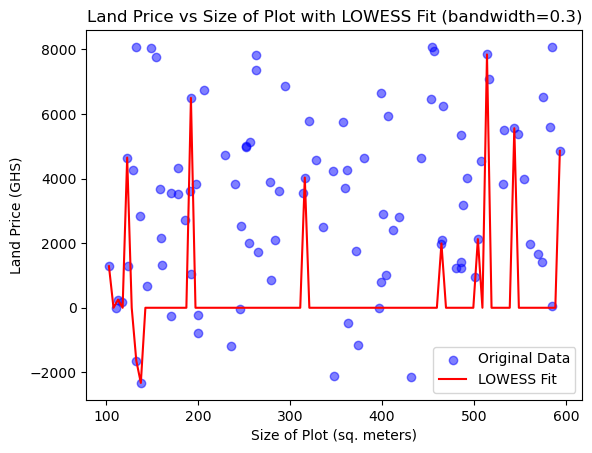

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the tricube kernel function
def tricube_kernel(x):
    """Tricube kernel for weighting."""
    abs_x = np.abs(x)
    return np.where(abs_x <= 1, (1 - abs_x**3)**3, 0)

# Function to calculate weights for each point based on distance and bandwidth
def calculate_weights(x_query, x_points, bandwidth):
    """Calculate the weights for each data point based on the distance from the query point."""
    distances = np.abs(x_points - x_query) / bandwidth
    return tricube_kernel(distances)

# LOWESS function implementation with regularization
def lowess(x, y, bandwidth=0.3, query_points=None, alpha=1e-5):
    """
    Locally Weighted Scatterplot Smoothing (LOWESS).
    
    Parameters:
    - x: Independent variable (e.g., "Size of Plot").
    - y: Dependent variable (e.g., "Land Price").
    - bandwidth: Controls the smoothing (0.001 to 1).
    - query_points: Points at which to evaluate the smoothed fit.
    - alpha: Regularization parameter to avoid singular matrix errors.
    
    Returns:
    - Smoothed values corresponding to the query points.
    """
    n = len(x)
    
    # If no query points are provided, use x as query points
    if query_points is None:
        query_points = np.linspace(np.min(x), np.max(x), n)
    
    y_smoothed = np.zeros_like(query_points)
    
    # Loop over each query point to perform weighted regression
    for i, x_query in enumerate(query_points):
        # Calculate weights based on the current query point
        weights = calculate_weights(x_query, x, bandwidth)
        
        # Apply weights to the data
        W = np.diag(weights)
        
        # Perform weighted linear regression: y = b0 + b1 * x
        X = np.c_[np.ones(n), x]  # Design matrix with intercept term
        
        # Regularization: Add alpha * Identity matrix to avoid singular matrix
        XtWX = X.T @ W @ X + alpha * np.eye(X.shape[1])
        
        # Solve the regularized weighted least squares problem
        theta = np.linalg.inv(XtWX) @ X.T @ W @ y
        
        # Predict the y value for the query point using the fitted parameters
        y_smoothed[i] = np.array([1, x_query]) @ theta
    
    return query_points, y_smoothed

# Simulate the data as provided earlier
np.random.seed(42)
num_samples = 100
size_of_plot = np.random.uniform(100, 600, num_samples)
distance_from_airport = np.random.uniform(5, 30, num_samples)
proximity_to_main_road = np.random.uniform(1, 10, num_samples)
proximity_to_city_center = np.random.uniform(5, 25, num_samples)

land_price = (size_of_plot ** 1.2) + (distance_from_airport ** 0.5) * 1000 - (proximity_to_main_road ** 2) * 50 + np.random.normal(0, 2000, num_samples)

# Create a DataFrame for the simulated data
simulated_data = pd.DataFrame({
    'Size of Plot (sq. meters)': size_of_plot,
    'Distance from Airport (km)': distance_from_airport,
    'Proximity to Main Road (km)': proximity_to_main_road,
    'Proximity to City Center (km)': proximity_to_city_center,
    'Land Price (GHS)': land_price
})

# Apply the LOWESS smoothing
x = simulated_data['Size of Plot (sq. meters)'].values
y = simulated_data['Land Price (GHS)'].values

# Perform LOWESS with a custom bandwidth
bandwidth = 0.3  # You can vary this value to test different smoothing levels
size_of_plot_smooth, land_price_smooth = lowess(x, y, bandwidth)

# Plot the original data and the LOWESS smoothed line
plt.scatter(x, y, color='blue', alpha=0.5, label='Original Data')
plt.plot(size_of_plot_smooth, land_price_smooth, color='red', label='LOWESS Fit')

# Add labels and title
plt.xlabel("Size of Plot (sq. meters)")
plt.ylabel("Land Price (GHS)")
plt.title(f"Land Price vs Size of Plot with LOWESS Fit (bandwidth={bandwidth})")
plt.legend()
plt.show()
